## Test: Determine Lambda empirically

In [1]:
# General
import glob
import re
import os.path
import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Statistics
from sklearn.linear_model import LinearRegression
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'n':              5, # R+ is defined as omega(R+) = n * f
    'sav_fgs':        True,
}

PTHS = {
    'dsg_pth':         '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
    'sav_dir':         '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_TIME_EVOLUTION/zTest_Determine_Lambda/'
}

### 1) FUNCTIONS

In [3]:
rs = np.linspace(10, 900000, 90000)
dr = 10 # meters

# rs = np.linspace(10000, 900000, 90)
# dr = 10000 # meters

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    return (1 / r) * np.gradient(r * v, dr)

def v_k10(v0, t, alpha=1., lbda=None):
    # Initial
    v          = np.zeros_like(v0.rad)                             # Raw v0
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(alpha * t)})    # Inner-core: v0 interpolated on r * e^t
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + alpha * t)) # Near-core (1)
    v_prop_nr  = v0.interp({'rad': nr_term})                       # Near-core (2)
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * alpha * t)              # Outer-core (1)
    v_prop_ou  = v0.interp({'rad': ou_term})                       # Outer-core (2)
    
    # No friction
    if lbda is None:
        vin        = v_prop_in * np.exp(alpha * t) + v0.rad * (np.exp(2 * alpha * t) - 1) / (2 * alpha)                                     # Inner-core
        vnr        = nr_term * v_prop_nr / v0.rad + (1 - v0.rad ** 2) / (2 * alpha * v0.rad) + np.log(v0.rad) / v0.rad + alpha * t / v0.rad # Near-core
        vou        = ou_term * v_prop_ou / v0.rad + alpha * t / v0.rad                                                                      # Outer-core
        
    # Friction
    else:
        vin        = v_prop_in * np.exp((alpha - lbda) * t) + alpha * v0.rad * (1 - np.exp((2 * alpha - lbda) * t)) / (lbda - 2 * alpha)                                # Inner-core
        vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + alpha * (lbda * v0.rad ** 2 - 2 * alpha * v0.rad ** (lbda / alpha)) / (lbda * v0.rad * (lbda - 2 * alpha)) - alpha * np.exp(-lbda * t) / (lbda * v0.rad)
        vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + alpha * (1 - np.exp(-lbda * t)) / (lbda * v0.rad) # Outer-core

    # Declare final output
    bd              = np.exp(-alpha * t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

def compute_RV_plus(r, V, fcor, n=5):
    # Compute R+
    rm       = r[np.nanargmax(V)]
    out      = r > rm          # To find outer-core
    r        = r[out]
    V        = V[out]
    vrt      = vorticity(r, V) # Relative vorticity
    vrt_plan = fcor            # Planetary vorticity

    try: 
        R_plus = r[abs(vrt - n * vrt_plan) < 1e-6][0] # R+
        V_plus = V[r >= R_plus][0]
    except IndexError:
        print('Error: R+ non defined.')
        R_plus = V_plus = np.nan
    
    return R_plus, V_plus

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

def BL_height(r, a):
    '''a is the slope of the BL height'''
    return a * r

# def BL_height(r, a, Rp):
#     return a * (1 - np.exp(-(r / Rp) ** 0.1))

# def BL_height(r, a, Rp):
#     return (2 * a / np.pi) * np.arctan((r / Rp))

def u(r, alpha, fcor_ini, Rp_ini):
    u    = np.zeros_like(r) 
    u_in = -alpha * fcor_ini * r
    u_ou = -alpha * fcor_ini * (Rp_ini ** 2) / r
    u[r <= Rp_ini] = u_in[r <= Rp_ini]
    u[r >= Rp_ini] = u_ou[r >= Rp_ini]
    return u # dimensional

def propagate(r, a, alpha, V_ini, fcor_ini, dt=1, fitting_mode=False, Cd_plus=2.5e-3):
    # Compute R+, V+
    R_plus, V_plus = compute_RV_plus(r, V_ini, fcor_ini, PRMS['n'])
    # print('R+ = {:.0f}, V+ = {:.1f}'.format(R_plus, V_plus))
    
    # Compute BL height 
    h              = BL_height(r, a / 1000)
    # h                = a * np.ones_like(r)
    # h              = BL_height(r, a, R_plus)
    
    # Compute lambda
    # M_abs          = r * V_ini + 0.5 * fcor_ini * (r ** 2)
    M_rel          = r * V_ini
    lbda           = float(Cd_plus * R_plus * (V_plus ** 2)) / (h * M_rel) # dimensional
    # lbda           = float(Cd_plus * R_plus * (V_plus ** 2)) / (h * M_rel) - (fcor_ini * r * u(r, alpha, fcor_ini, R_plus) / M_rel) # dimensional
    lbda           = lbda / fcor_ini                                       # non-dimensional
    
    # plt.plot(r / 1000, 1e6 / r ** 2, c='k')
    # plt.plot(r / 1000, lbda);plt.yscale('log');plt.xlim(0, 300);plt.show()
    
    # Normalize
    V_nrm = xr.DataArray(
        data=V_ini / (fcor_ini * R_plus),
        coords={'rad': r / R_plus}
    )
    
    # Apply KK10
    V = v_k10(V_nrm, dt, alpha, lbda=lbda) * fcor_ini * R_plus             # dimensional
    
    # # Option 1: Fit the whole curve
    # # In fitting mode, match values of nan with values of initial profile so that it doesn't count
    # if fitting_mode:
    #     V[np.isnan(V)] = V_ini[np.isnan(V)]
    
    # Option 2: Fit Vmax
    if fitting_mode:
        V = np.nanmax(V)

    return V

### 2) SAR DATA

In [4]:
dsg  = xr.open_dataset(PTHS['dsg_pth'])

### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
dsg = dsg.where(dsg.B_hol > 0.1, drop=True)
dsg = dsg.where(dsg.Vmax_1D > 25, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

print('SAR Mean Rmax = {:.0f} km'.format(dsg.Rmax_1D.mean()))
print('SAR Mean R64  = {:.0f} km'.format(dsg.R33_1D.mean()))

# Manually add Goni because its R17 is nan (I don't know why)
goni      = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/Goni_sample.nc')
goni['storm_id'] = np.array('wp222020')
dsg       = xr.concat((dsg, goni), dim='time')

# Select IDs where there are at least 2 SAR images
ids, cts  = np.unique(dsg.storm_id, return_counts=True)
valid_ids = ids[cts > 1]
valid_cts = cts[cts > 1]

print('Mean latitude = {:.1f}°'.format(abs(dsg.lat_center).mean()))
print('Mean Coriolis = {:.1e}'.format(float(coriolis(abs(dsg.lat_center).mean()))))

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Nb of storms: 161
SAR Mean Rmax = 31 km
SAR Mean R64  = 57 km
Mean latitude = 18.9°
Mean Coriolis = 4.7e-05


### 3) Determine lambda

In [5]:
# Parameters
time_thresh  = 20

# id = 3, 10, 15, 20, 25, 30, 35
# Intensifying: 3, 40

# Iterate
for tc_id in tqdm(valid_ids[:14]):
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    for idx_ini in range(len(dsi.time) - 1):
        for idx_fin in range(idx_ini + 1, len(dsi.time)):
            # print(idx_ini, idx_fin)
            ds_ini     = dsi.isel(time=idx_ini)
            ds_fin     = dsi.isel(time=idx_fin)   
            delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
            # Compute VK10 if delta_h is less than threshold
            if (delta_h <= time_thresh) & (delta_h > 1):
                V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
                Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
                fcor_ini   = float(abs(coriolis(ds_ini.lat_center)))
                fcor_fin   = float(abs(coriolis(ds_fin.lat_center)))
                
                # Compute R+ metrics
                Rp_ini, Vp_ini   = compute_RV_plus(rs, Vh_ini,    float(abs(coriolis(ds_ini.lat_center))), PRMS['n'])
                
                # dt
                tau      = ((1 / fcor_ini) / 3600)
                dt       = delta_h / tau
                
                # Alpha
                alpha = 1

  0%|          | 0/14 [00:00<?, ?it/s]

In [49]:
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings("ignore")

def propagate(r, lbda, V_ini, fcor_ini, dt=1, alpha=1, Cd_plus=2.5e-3):
    # Compute R+, V+
    R_plus, V_plus = compute_RV_plus(r, V_ini, fcor_ini, PRMS['n'])
    
    # Normalize
    V_nrm = xr.DataArray(
        data=V_ini / (fcor_ini * R_plus),
        coords={'rad': r / R_plus}
    )
    # lbda = lbda / fcor_ini                                       # non-dimensional
    
    # Apply KK10
    V = v_k10(V_nrm, dt, alpha, lbda=lbda) * fcor_ini * R_plus # dimensional

    return V

def local_loss(lbda, i, V_ini, V_fin, dt, alpha):
    V_mod = propagate(rs, lbda, V_ini, fcor_ini, dt=dt, alpha=alpha)
    # print(lbda)
    # print(lbda, V_ini[i], V_mod[i])
    return np.sqrt((V_fin[i] - V_mod[i]) ** 2)

In [24]:
# Parameters
time_thresh  = 20
lbda0        = 0.7
alpha        = 1

# Iterate
for tc_id in tqdm(valid_ids):
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    for idx_ini in range(len(dsi.time) - 1):
        for idx_fin in range(idx_ini + 1, len(dsi.time)):
            # print(idx_ini, idx_fin)
            ds_ini     = dsi.isel(time=idx_ini)
            ds_fin     = dsi.isel(time=idx_fin)   
            delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
            # Compute VK10 if delta_h is less than threshold
            if (delta_h <= time_thresh) & (delta_h > 1):
                V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
                Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
                fcor_ini   = float(abs(coriolis(ds_ini.lat_center)))
                fcor_fin   = float(abs(coriolis(ds_fin.lat_center)))
                
                # Compute R+ metrics
                Rp_ini, Vp_ini   = compute_RV_plus(rs, Vh_ini, float(abs(coriolis(ds_ini.lat_center))), PRMS['n'])
                
                # dt
                tau      = ((1 / fcor_ini) / 3600)
                dt       = delta_h / tau
                
                # Plot profiles
                plt.plot(rs / 1000, Vh_ini, c='k', label='SAR ini', linewidth=3)
                plt.plot(rs / 1000, Vh_fin, c='orangered', label='SAR fin', linewidth=3)
                plt.xlim(0, 300)
                plt.grid();plt.legend()
                if PRMS['sav_fgs']:
                    plt.savefig(PTHS['sav_dir'] + '{}_idx_ini{}_idx_fin{}_profiles'.format(tc_id.item(), idx_ini, idx_fin))
                plt.clf()
                
                # Determine lambda - coarse
                LBDAS = []
                IS    = []
                for i in tqdm(rs[999::1000][:10]):
                    i     = int(i / 10)
                    opt   = minimize_scalar(local_loss, args=(i, Vh_ini, Vh_fin, dt, alpha), tol=1e-5)
                    V     = propagate(rs, opt.x, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
                    if abs(Vh_fin[i] - V[i]) > 1:
                        print('ERROR')
                        # print('FINAL LBDA = {}'.format(opt.x))
                        print(i, Vh_fin[i], V[i])
                    # Append
                    LBDAS.append(opt.x)
                    IS.append(i)
                plt.scatter(rs[IS] / 1000, LBDAS, c='tab:blue')
                
                # Determine lambda - fine
                LBDAS = []
                IS    = []
                for i in tqdm(rs[::100][:10]):
                    i     = int(i / 10)
                    opt   = minimize_scalar(local_loss, args=(i, Vh_ini, Vh_fin, dt, alpha), tol=1e-5)
                    V     = propagate(rs, opt.x, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
                    if abs(Vh_fin[i] - V[i]) > 1:
                        print('ERROR')
                        print(i, Vh_fin[i], V[i])
                    # Append
                    LBDAS.append(opt.x)
                    IS.append(i)
                plt.scatter(rs[IS] / 1000, LBDAS, c='tab:blue')
                
                # Plot lambda
                plt.plot(rs / 1000, 0.06 * Rp_ini ** 2 / (rs ** 2), c='r', label='0.06 * R+^2 / r^2')
                plt.plot(rs / 1000, 0.2 * (Rp_ini / rs) ** 1, c='g', label='0.2 * R+ / r')
                plt.plot(rs / 1000, 0.02 * (Rp_ini ** 2 * Vp_ini / (rs ** 2 * Vh_ini)), c='gray', label='0.02 * R+^2 * V+ / (r^2 * v)')
                plt.xlim(-1, 100)
                plt.ylim(0, 2)
                plt.grid();plt.legend()
                if PRMS['sav_fgs']:
                    plt.savefig(PTHS['sav_dir'] + '{}_idx_ini{}_idx_fin{}_lambdas'.format(tc_id.item(), idx_ini, idx_fin))
                plt.clf()

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


KeyboardInterrupt



<Figure size 1500x1000 with 0 Axes>

In [76]:
lbda_candidates = np.linspace(1, 100, 20)
lbda_candidates

array([  1.        ,   6.21052632,  11.42105263,  16.63157895,
        21.84210526,  27.05263158,  32.26315789,  37.47368421,
        42.68421053,  47.89473684,  53.10526316,  58.31578947,
        63.52631579,  68.73684211,  73.94736842,  79.15789474,
        84.36842105,  89.57894737,  94.78947368, 100.        ])

### Alpha = 0.5

In [79]:
# Parameters
time_thresh     = 20
lbda0           = 0.7
alpha           = 0.5
# lbda_candidates = np.linspace(0.01, 3, 20)
lbda_candidates = np.concatenate(([0.00001, 0.0001, 0.0005, 0.001, 0.003, 0.006, 0.01], np.linspace(0.05, 2, 20))) # alpha = 0.5
# lbda_candidates = np.linspace(0.1, 15, 30)

# Iterate
for tc_id in tqdm(valid_ids):
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    for idx_ini in range(len(dsi.time) - 1):
        for idx_fin in range(idx_ini + 1, len(dsi.time)):
            # print(idx_ini, idx_fin)
            ds_ini     = dsi.isel(time=idx_ini)
            ds_fin     = dsi.isel(time=idx_fin)   
            delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
            # Compute VK10 if delta_h is less than threshold
            if (delta_h <= time_thresh) & (delta_h > 1):
                V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
                Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
                fcor_ini   = float(abs(coriolis(ds_ini.lat_center)))
                fcor_fin   = float(abs(coriolis(ds_fin.lat_center)))
                
                # Compute R+ metrics
                Rp_ini, Vp_ini   = compute_RV_plus(rs, Vh_ini, float(abs(coriolis(ds_ini.lat_center))), PRMS['n'])
                
                # dt
                tau      = ((1 / fcor_ini) / 3600)
                dt       = delta_h / tau
                
                # Plot profiles
                plt.plot(rs / 1000, Vh_ini, c='k', label='SAR ini', linewidth=3)
                plt.plot(rs / 1000, Vh_fin, c='orangered', label='SAR fin', linewidth=3)
                plt.xlim(0, 300)
                plt.grid();plt.legend()
                if PRMS['sav_fgs']:
                    plt.savefig(PTHS['sav_dir'] + '{}_idx_ini{}_idx_fin{}_profiles'.format(tc_id.item(), idx_ini, idx_fin))
                plt.clf()
                
                # Determine lambda - coarse
                LBDAS = []
                IS    = []
                for i in tqdm(rs[999::1000][:10]):
                    i     = int(i / 10)
                    
                    losses = []
                    for l in lbda_candidates:
                        lss = local_loss(l, i, Vh_ini, Vh_fin, dt, alpha)
                        losses.append(lss)
                    res = lbda_candidates[np.nanargmin(losses)]
                    
                    V     = propagate(rs, res, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
                    if abs(Vh_fin[i] - V[i]) > 3:
                        print('ERROR')
                        print('FINAL LBDA = {}'.format(res))
                        print(i, Vh_fin[i], V[i])
                    # Append
                    LBDAS.append(res)
                    IS.append(i)
                plt.scatter(rs[IS] / 1000, LBDAS, c='tab:blue')
                
                # Determine lambda - fine
                LBDAS = []
                IS    = []
                for i in tqdm(rs[::100][:10]):
                    i     = int(i / 10)
                    
                    losses = []
                    for l in lbda_candidates:
                        lss = local_loss(l, i, Vh_ini, Vh_fin, dt, alpha)
                        losses.append(lss)
                    res = lbda_candidates[np.nanargmin(losses)]
                    
                    V     = propagate(rs, res, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
                    if abs(Vh_fin[i] - V[i]) > 3:
                        print('ERROR')
                        print('FINAL LBDA = {}'.format(res))
                        print(i, Vh_fin[i], V[i])
                    # Append
                    LBDAS.append(res)
                    IS.append(i)
                plt.scatter(rs[IS] / 1000, LBDAS, c='tab:blue')
                
                # Plot lambda
                plt.plot(rs / 1000, 0.06 * Rp_ini ** 2 / (rs ** 2), c='r', label='0.06 * R+^2 / r^2')
                plt.plot(rs / 1000, 0.2 * (Rp_ini / rs) ** 1, c='g', label='0.2 * R+ / r')
                plt.plot(rs / 1000, 0.02 * (Rp_ini ** 2 * Vp_ini / (rs ** 2 * Vh_ini)), c='gray', label='0.02 * R+^2 * V+ / (r^2 * v)')
                plt.xlim(-1, 100)
                plt.ylim(0, 2)
                plt.grid();plt.legend()
                if PRMS['sav_fgs']:
                    plt.savefig(PTHS['sav_dir'] + '{}_idx_ini{}_idx_fin{}_lambdas'.format(tc_id.item(), idx_ini, idx_fin))
                plt.clf()

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1e-05
8000 43.56184128999603 40.21563890965484
ERROR
FINAL LBDA = 1e-05
9000 40.834336144180945 36.11023528733816
ERROR
FINAL LBDA = 1e-05
10000 38.03768583847293 32.83040521144442


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 0.15263157894736842
7000 38.27313037646122 41.93008387927398



KeyboardInterrupt



<Figure size 1500x1000 with 0 Axes>

### Alpha = 10

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.1275862068965519
5000 42.733730670513545 50.86213537316429
ERROR
FINAL LBDA = 1.1275862068965519
6000 46.191267762432524 42.73341256227337
ERROR
FINAL LBDA = 1.1275862068965519
7000 45.71934362230723 36.75009195962985
ERROR
FINAL LBDA = 1.1275862068965519
8000 43.56184128999603 32.17534613161303
ERROR
FINAL LBDA = 0.6137931034482759
9000 40.834336144180945 50.49676843814559
ERROR
FINAL LBDA = 0.6137931034482759
10000 38.03768583847293 45.499098481840626


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.6413793103448278
6000 37.924496927499305 42.44107899823981
ERROR
FINAL LBDA = 1.6413793103448278
8000 37.22843029253929 32.30220389020731
ERROR
FINAL LBDA = 1.1275862068965519
9000 35.56601259231838 42.34506648810088
ERROR
FINAL LBDA = 1.1275862068965519
10000 33.68263071132725 38.11658205228998


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.1275862068965519
2000 57.0778250356448 68.34564392869291
ERROR
FINAL LBDA = 1.1275862068965519
3000 61.60867192818028 47.15922105895005
ERROR
FINAL LBDA = 0.6137931034482759
4000 54.07235374336616 61.00098291530853


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.1275862068965519
2000 49.55376887261109 36.77034480202663
ERROR
FINAL LBDA = 0.6137931034482759
3000 38.21356191677074 46.70578795050286
ERROR
FINAL LBDA = 0.6137931034482759
4000 30.72111622372971 35.19849059282682


  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 2.6689655172413795
801 26.658829596037936 22.801759922152723
ERROR
FINAL LBDA = 2.1551724137931036
901 34.81836460126533 29.14237784587668


  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.6413793103448278
1000 41.65488498356725 38.5705646686472
ERROR
FINAL LBDA = 0.6137931034482759
2000 49.55376887261109 63.39516226731049
ERROR
FINAL LBDA = 0.6137931034482759
3000 38.21356191677074 42.82013596960468


  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 2.1551724137931036
801 26.658829596037936 30.629809798514334
ERROR
FINAL LBDA = 2.1551724137931036
901 34.81836460126533 27.80317454730105


  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.6413793103448278
1000 34.09466204441958 39.67136035250441
ERROR
FINAL LBDA = 1.1275862068965519
3000 30.362156138703575 24.103050140073687
ERROR
FINAL LBDA = 1.1275862068965519
4000 25.697208379860918 18.172056775950693
ERROR
FINAL LBDA = 0.6137931034482759
5000 22.338541583895125 27.427472813646666
ERROR
FINAL LBDA = 0.6137931034482759
6000 19.842185164736733 22.927562974631634


  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 2.6689655172413795
801 27.194707851854773 23.104528407651905


  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.1275862068965519
2000 50.19119497260606 45.81750591630713
ERROR
FINAL LBDA = 1.1275862068965519
3000 42.18906178377221 31.336290058764803
ERROR
FINAL LBDA = 0.6137931034482759
4000 34.586790244765716 44.719663856440356
ERROR
FINAL LBDA = 0.6137931034482759
5000 29.324460265268737 35.86876513773797
ERROR
FINAL LBDA = 0.6137931034482759
6000 25.646834325590525 29.975857180132707


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 2.6689655172413795
1000 28.817120832656713 25.133646913571692
ERROR
FINAL LBDA = 1.1275862068965519
3000 41.478727750712174 32.68882108187458
ERROR
FINAL LBDA = 0.6137931034482759
4000 34.822735650080226 41.82048402562135
ERROR
FINAL LBDA = 0.6137931034482759
5000 29.864526922723915 33.577569364751064


  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 3.1827586206896554
901 23.025997708600272 19.987903782946237


  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.1275862068965519
3000 48.2083295171739 37.86777639648422
ERROR
FINAL LBDA = 1.1275862068965519
4000 40.428456693630324 28.767298876866338
ERROR
FINAL LBDA = 0.6137931034482759
5000 34.477969096936775 42.88652681968844
ERROR
FINAL LBDA = 0.6137931034482759
6000 30.036440262287964 35.84737175513603
ERROR
FINAL LBDA = 0.6137931034482759
7000 26.64706515398859 30.835346278652505
ERROR
FINAL LBDA = 0.6137931034482759
8000 23.988160160384464 27.09015567403141


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.6413793103448278
4000 27.14234204442124 22.689534689516844
ERROR
FINAL LBDA = 1.1275862068965519
5000 24.693746346031634 28.88975810737575
ERROR
FINAL LBDA = 1.1275862068965519
10000 17.93172340283351 14.612441014680234


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.6413793103448278
2000 36.56314297345139 40.70685496478069
ERROR
FINAL LBDA = 1.1275862068965519
3000 38.5694060285854 46.349618280283806
ERROR
FINAL LBDA = 1.1275862068965519
5000 33.03032099214414 28.417460763194757
ERROR
FINAL LBDA = 1.1275862068965519
6000 30.272858993162593 23.722033230867
ERROR
FINAL LBDA = 1.1275862068965519
7000 27.90282498542202 20.37078688667693
ERROR
FINAL LBDA = 0.6137931034482759
8000 25.88387080993358 32.99581754052513
ERROR
FINAL LBDA = 0.6137931034482759
9000 24.155962990657912 29.427008191680823
ERROR
FINAL LBDA = 0.6137931034482759
10000 22.66439449743793 26.581688945234436


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 2.1551724137931036
3000 38.96272052102802 33.180763539866874
ERROR
FINAL LBDA = 1.6413793103448278
5000 36.43894045895904 30.04363477235111
ERROR
FINAL LBDA = 1.1275862068965519
6000 33.49890548724898 38.19955824680056


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.6413793103448278
4000 33.74402622374575 37.91332555023312
ERROR
FINAL LBDA = 1.6413793103448278
5000 38.03986391973655 30.973133636708862
ERROR
FINAL LBDA = 1.1275862068965519
8000 34.97296507760964 30.491417743854104
ERROR
FINAL LBDA = 1.1275862068965519
9000 32.9657510785178 27.132720974734866
ERROR
FINAL LBDA = 1.1275862068965519
10000 31.072067285891137 24.448685764909314


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.6413793103448278
4000 41.85195308320356 46.10699612110162
ERROR
FINAL LBDA = 1.6413793103448278
5000 44.21989464796439 37.74778673980167
ERROR
FINAL LBDA = 1.1275862068965519
6000 42.62512677340857 49.92747978012838
ERROR
FINAL LBDA = 1.1275862068965519
7000 39.870626849119496 43.083782110441106


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.6413793103448278
8000 27.827332740454448 22.869923690525894
ERROR
FINAL LBDA = 1.1275862068965519
9000 26.913333884531756 30.192196181935593


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.1275862068965519
2000 49.922372687002856 57.86990039390866
ERROR
FINAL LBDA = 1.1275862068965519
3000 43.49615184645914 39.600326025160356
ERROR
FINAL LBDA = 1.1275862068965519
4000 36.78129264609789 30.102725558587583
ERROR
FINAL LBDA = 1.1275862068965519
5000 31.772831105857172 24.207699222539166
ERROR
FINAL LBDA = 0.6137931034482759
6000 28.076710317955243 34.394585304790375
ERROR
FINAL LBDA = 0.6137931034482759
7000 25.27451703996043 29.58002233764288


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.6413793103448278
7000 36.07149638272345 40.166813026461334
ERROR
FINAL LBDA = 1.6413793103448278
9000 36.2841071358885 31.48223054758412
ERROR
FINAL LBDA = 1.1275862068965519
10000 35.03674646254078 41.34063502853193


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 2.1551724137931036
8000 32.068115944807595 28.601247269033895
ERROR
FINAL LBDA = 1.6413793103448278
9000 30.268500201456437 33.82930285049567


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.1275862068965519
3000 44.264557613355386 51.51686637959099
ERROR
FINAL LBDA = 1.1275862068965519
10000 19.06250530658198 16.00017174212737


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR
FINAL LBDA = 1.6413793103448278
5000 31.37129325861244 25.541993424155194
ERROR
FINAL LBDA = 1.1275862068965519
8000 28.090786020473633 24.176728951135928
ERROR
FINAL LBDA = 1.1275862068965519
9000 26.919972287754053 21.498777639382375
ERROR
FINAL LBDA = 1.1275862068965519
10000 25.805463541460536 19.35719699532234


  0%|          | 0/10 [00:00<?, ?it/s]

AttributeError: 'str' object has no attribute 'item'

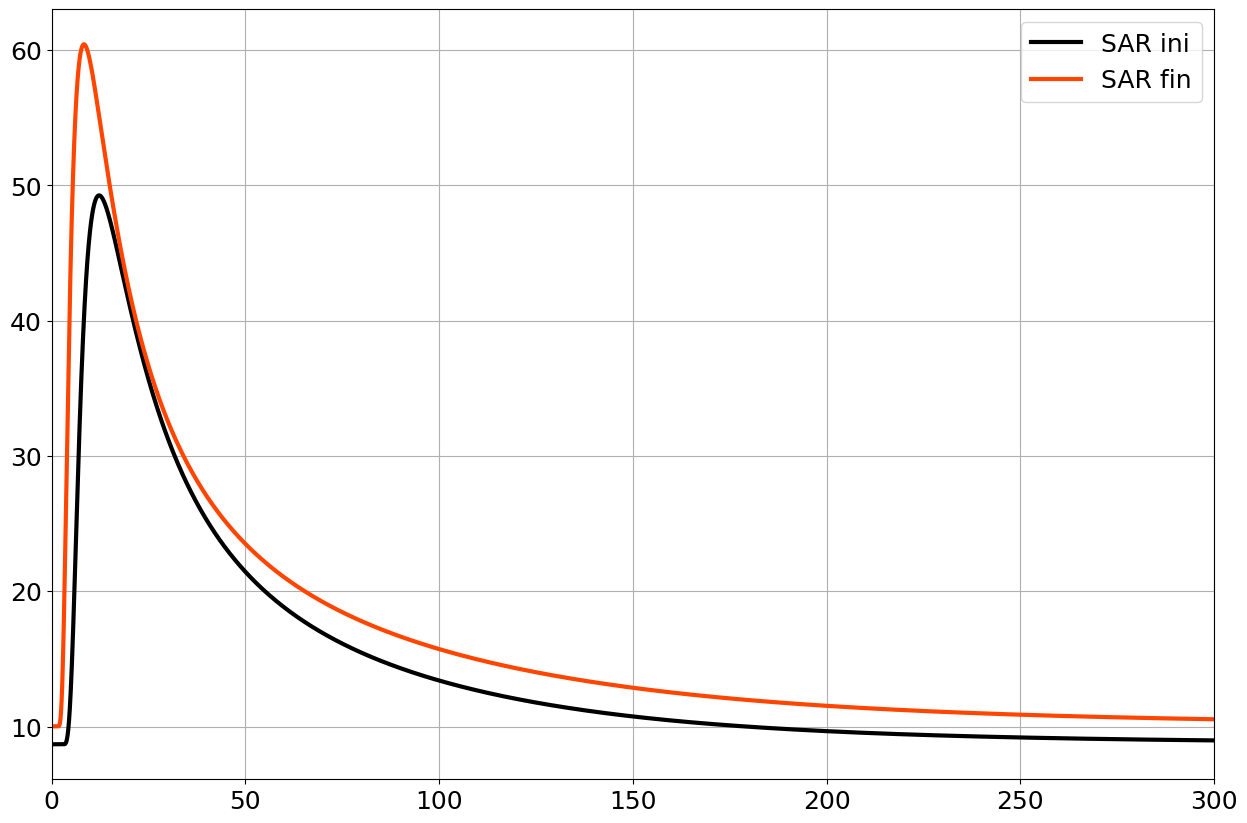

In [92]:
# Parameters
time_thresh     = 20
lbda0           = 0.7
alpha           = 10
lbda_candidates = np.linspace(0.1, 15, 30)

# Iterate
for tc_id in tqdm(valid_ids):
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    for idx_ini in range(len(dsi.time) - 1):
        for idx_fin in range(idx_ini + 1, len(dsi.time)):
            # print(idx_ini, idx_fin)
            ds_ini     = dsi.isel(time=idx_ini)
            ds_fin     = dsi.isel(time=idx_fin)   
            delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
            # Compute VK10 if delta_h is less than threshold
            if (delta_h <= time_thresh) & (delta_h > 1):
                V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
                Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
                fcor_ini   = float(abs(coriolis(ds_ini.lat_center)))
                fcor_fin   = float(abs(coriolis(ds_fin.lat_center)))
                
                # Compute R+ metrics
                Rp_ini, Vp_ini   = compute_RV_plus(rs, Vh_ini, float(abs(coriolis(ds_ini.lat_center))), PRMS['n'])
                
                # dt
                tau      = ((1 / fcor_ini) / 3600)
                dt       = delta_h / tau
                
                # Plot profiles
                plt.plot(rs / 1000, Vh_ini, c='k', label='SAR ini', linewidth=3)
                plt.plot(rs / 1000, Vh_fin, c='orangered', label='SAR fin', linewidth=3)
                plt.xlim(0, 300)
                plt.grid();plt.legend()
                if PRMS['sav_fgs']:
                    plt.savefig(PTHS['sav_dir'] + '{}_idx_ini{}_idx_fin{}_profiles'.format(tc_id.item(), idx_ini, idx_fin))
                plt.clf()
                
                # Determine lambda - coarse
                LBDAS = []
                IS    = []
                for i in tqdm(rs[999::1000][:10]):
                    i     = int(i / 10)
                    
                    losses = []
                    for l in lbda_candidates:
                        lss = local_loss(l, i, Vh_ini, Vh_fin, dt, alpha)
                        losses.append(lss)
                    res = lbda_candidates[np.nanargmin(losses)]
                    
                    V     = propagate(rs, res, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
                    if abs(Vh_fin[i] - V[i]) > 3:
                        print('ERROR')
                        print('FINAL LBDA = {}'.format(res))
                        print(i, Vh_fin[i], V[i])
                    # Append
                    LBDAS.append(res)
                    IS.append(i)
                plt.scatter(rs[IS] / 1000, LBDAS, c='tab:blue')
                
                # Determine lambda - fine
                LBDAS = []
                IS    = []
                for i in tqdm(rs[::100][:10]):
                    i     = int(i / 10)
                    
                    losses = []
                    for l in lbda_candidates:
                        lss = local_loss(l, i, Vh_ini, Vh_fin, dt, alpha)
                        losses.append(lss)
                    res = lbda_candidates[np.nanargmin(losses)]
                    
                    V     = propagate(rs, res, Vh_ini, fcor_ini, dt=dt, alpha=alpha)
                    if abs(Vh_fin[i] - V[i]) > 3:
                        print('ERROR')
                        print('FINAL LBDA = {}'.format(res))
                        print(i, Vh_fin[i], V[i])
                    # Append
                    LBDAS.append(res)
                    IS.append(i)
                plt.scatter(rs[IS] / 1000, LBDAS, c='tab:blue')
                
                # Plot lambda
                plt.plot(rs / 1000,  Rp_ini ** 2 / (rs ** 2), c='r', label='R+^2 / r^2')
                plt.plot(rs / 1000,  3 * (Rp_ini / rs) ** 1, c='g', label='3 * R+ / r')
                plt.plot(rs / 1000, (Rp_ini ** 2 * Vp_ini / (rs ** 2 * Vh_ini)), c='gray', label='R+^2 * V+ / (r^2 * v)')
                plt.xlim(-1, 100)
                plt.ylim(0, 15)
                plt.grid();plt.legend()
                if PRMS['sav_fgs']:
                    plt.savefig(PTHS['sav_dir'] + '{}_idx_ini{}_idx_fin{}_lambdas'.format(tc_id.item(), idx_ini, idx_fin))
                plt.clf()

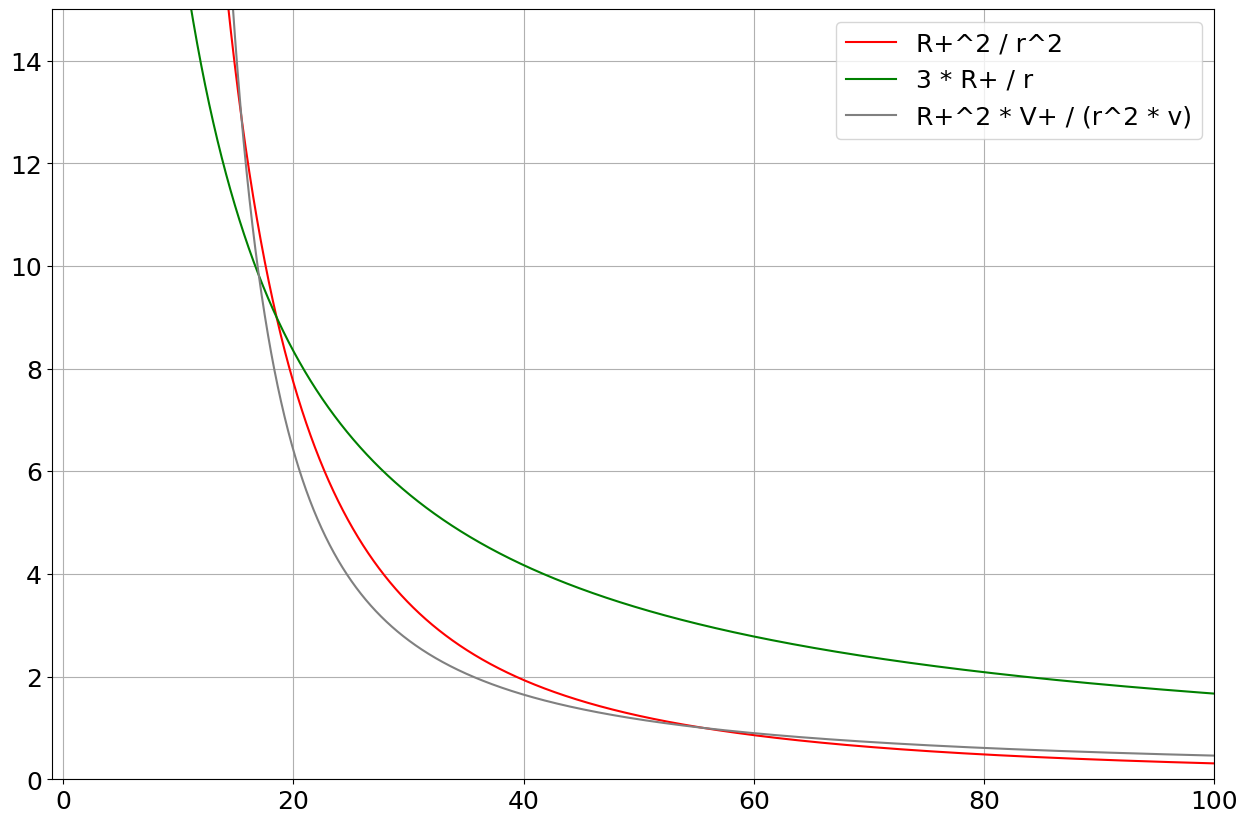

In [90]:
# Plot lambda
plt.plot(rs / 1000,  Rp_ini ** 2 / (rs ** 2), c='r', label='R+^2 / r^2')
plt.plot(rs / 1000,  3 * (Rp_ini / rs) ** 1, c='g', label='3 * R+ / r')
plt.plot(rs / 1000, (Rp_ini ** 2 * Vp_ini / (rs ** 2 * Vh_ini)), c='gray', label='R+^2 * V+ / (r^2 * v)')
plt.xlim(-1, 100)
plt.ylim(0, 15)
plt.grid();plt.legend()